<a href="https://colab.research.google.com/github/Nega0619/Aiffel_Submitted_Exploration_nodes/blob/main/CV_GoindDeeper_02_ResNet_Ablation_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

오늘은 ResNet을 실제로 구현해보면서 Ablation Study를 통해 resnet의 성능을 증명하려합니다.



In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# 1. cifar10 데이터셋 준비하기

In [3]:
# cifar10 데이터 로드
import urllib3

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True
)

In [4]:
# tensorflow 데이터셋을 로드한 후, feature 정보를 확인하는 방법
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [5]:
#데이터셋 개수 확인해보기
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


tensorflow의 데이터셋은 numpy가 아니므로, ds_train.shape가 존재하지 않습니다.

In [6]:
print(type(ds_train))

<class 'tensorflow.python.data.ops.dataset_ops.PrefetchDataset'>


궁금해서 알아보니, prefetchDataset이라는 데이터형식이었습니다.

# 2. Input data Normalization하기 

Data Normalization이란, 데이터의 스케일을 사용자가 원하는 스케일로 조정하는 것입니다.

이를 하면 얻을 수 있는 이점은, 

1.   머신러닝에서 scale이 큰 feature의 특징이 비대해지는 것을 막음
2.   딥러닝에서 local optimum을 더 잘 빠져나올 수있게 해줌



In [7]:
def normalize_and_resize_img(image, label):
    return tf.cast(image, tf.float32) / 255, label

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
ds_info.features['label'].num_classes

10

In [10]:
ds_info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

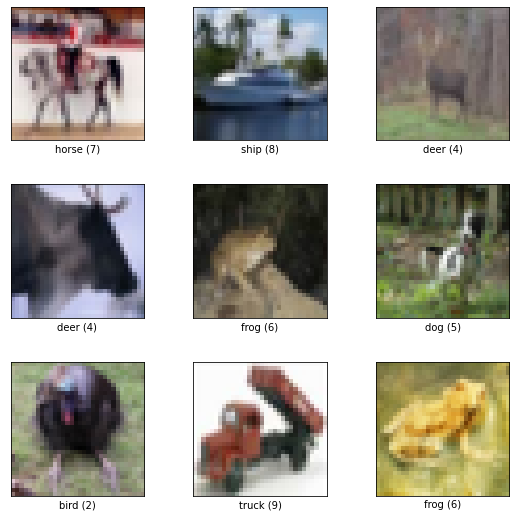

In [11]:
fig = tfds.show_examples(ds_train, ds_info)

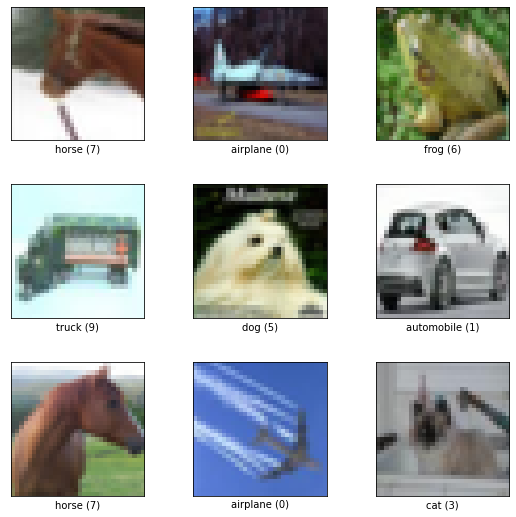

In [12]:
fig = tfds.show_examples(ds_test, ds_info)


# 3. Ablation Study 실습 : 블록 구성하기

블록이란, 딥러닝 모델 구현시 반복되는 단위입니다.
주요 구조를 모듈화 시켜 조금씩 바꾸어 쓸 수 있는 단위입니다.

### Resnet의 블록 구성

아래 표를 보면, ResNet-18, 34, 50, 101, 152 5가지 구성의 네트워크가 존재합니다.

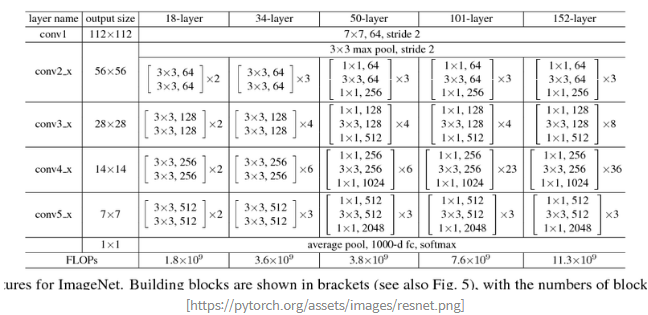

바로 Resnet 블록을 생성하는 것은 어려울 수 있으므로, 조금 더 간단한 구조인 VGG넷을 예시로 구현하겠습니다.

## 3-1. VGG넷 블록 구성하기

### VGG넷의 블록 구성

여기서 VGG-16과, 19를 구현할 예정입니다.

- VGG 넷의 특징
    1. 여러개의 CNN 레이어와 마지막엔 Max-Pooling
    2. 커널 크기가 (3*3)
    3. 블록 내 CNN 레이어의 채널은 하나로 유지 BUT 다른 블록의 CNN 레이어의 채널 수는 다를수 있음.
        따라서, CNN 레이어의 수와 채널을 조절할 수 있도록 블록을 구성해야 함!

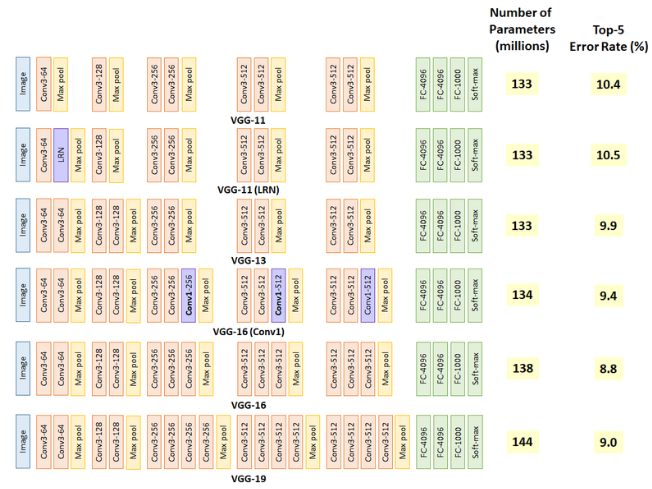

In [13]:
# function for building VGG Block
'''
@ param
    input_layer : input layer
    num_cnn     : cnn층이 반복되는 횟수
    channel     :
    block_num   : 레이어의 이름을 붙여주기 위해 추가
'''
def build_vgg_block(input_layer, num_cnn=3, channel=64, block_num=1):

    # 입력 레이어
    x = input_layer

    # cnn layer
    for n in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{n}'
        )(x)

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2,2),
        strides=2,
        name=f'blcok{block_num}_pooling'
    )(x)

    return x
    

In [14]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # cifar-10 데이터의 크기가 32,32,3
vgg_blcok_output = build_vgg_block(vgg_input_layer)     # VGG 블록 생성

In [15]:
# 블록 1개 짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_blcok_output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 blcok1_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________

## 3-2. VGG Complete

테스트가 완료되었으니, VGG-16과 19를 만들어봅니다.

### VGG-16

In [16]:
def build_vgg(
    input_shape=(32,32,3),
    num_cnn_list=[2,2,3,3,3],
    channel_list=[64,128,256,512,512],
    num_classes=10):

    assert len(num_cnn_list) == len(channel_list)

    input_layer = keras.layers.Input(shape=input_shape)
    output = input_layer

    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn,
            channel=channel,
            block_num=i
        )

    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)

    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

In [17]:
vgg_16 = build_vgg()
vgg_16.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 blcok0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

### VGG-19

In [18]:
vgg_19 = build_vgg(input_shape=(32,32,3),
                num_cnn_list=[2,2,4,4,4],
                channel_list=[64,128,256,512,512],
                num_classes=10)
vgg_19.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block0_conv0 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block0_conv1 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 blcok0_pooling (MaxPooling2  (None, 16, 16, 64)       0         
 D)                                                              
                                                                 
 block1_conv0 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block1_conv1 (Conv2D)       (None, 16, 16, 128)       147584    
                                                           

## 3-3 VGG-16, VGG-19

In [19]:
BATCH_SIZE = 256
EPOCH = 15

In [20]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [21]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 54s 130ms/step - loss: 2.1902 - accuracy: 0.1884 - val_loss: 2.0502 - val_accuracy: 0.2418
Epoch 2/15
195/195 [==============================] - 24s 123ms/step - loss: 1.9835 - accuracy: 0.2745 - val_loss: 1.8847 - val_accuracy: 0.3232
Epoch 3/15
195/195 [==============================] - 25s 127ms/step - loss: 1.8480 - accuracy: 0.3308 - val_loss: 1.7724 - val_accuracy: 0.3660
Epoch 4/15
195/195 [==============================] - 23s 120ms/step - loss: 1.7363 - accuracy: 0.3722 - val_loss: 1.6920 - val_accuracy: 0.4006
Epoch 5/15
195/195 [==============================] - 24s 122ms/step - loss: 1.6515 - accuracy: 0.4015 - val_loss: 1.5995 - val_accuracy: 0.4085
Epoch 6/15
195/195 [==============================] - 23s 120ms/step - loss: 1.5951 - accuracy: 0.4213 - val_loss: 1.5473 - val_accuracy: 0.4250
Epoch 7/15
195/195 [==============================] - 23s 120ms/step - loss: 1.5395 - accuracy: 0.4441 - val_loss: 1.5144 - val_accuracy: 0.4

In [22]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15
195/195 [==============================] - 32s 145ms/step - loss: 2.2364 - accuracy: 0.1646 - val_loss: 2.1480 - val_accuracy: 0.2093
Epoch 2/15
195/195 [==============================] - 28s 142ms/step - loss: 2.0356 - accuracy: 0.2570 - val_loss: 1.9665 - val_accuracy: 0.2788
Epoch 3/15
195/195 [==============================] - 28s 145ms/step - loss: 1.9021 - accuracy: 0.3088 - val_loss: 1.8534 - val_accuracy: 0.3184
Epoch 4/15
195/195 [==============================] - 27s 139ms/step - loss: 1.7862 - accuracy: 0.3545 - val_loss: 1.7088 - val_accuracy: 0.3852
Epoch 5/15
195/195 [==============================] - 27s 140ms/step - loss: 1.6893 - accuracy: 0.3884 - val_loss: 1.6623 - val_accuracy: 0.4107
Epoch 6/15
195/195 [==============================] - 28s 141ms/step - loss: 1.6232 - accuracy: 0.4099 - val_loss: 1.5812 - val_accuracy: 0.4243
Epoch 7/15
195/195 [==============================] - 29s 148ms/step - loss: 1.5629 - accuracy: 0.4367 - val_loss: 1.5278 - val_ac

## 3-4 VGG-16, VGG-19 결과 비교

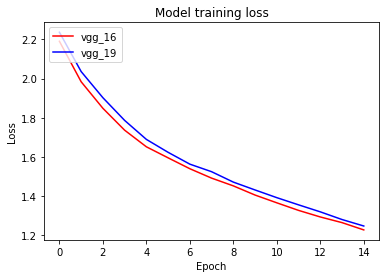

In [23]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

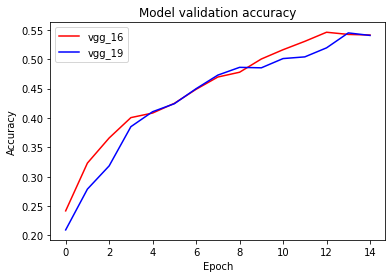

In [24]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

# 4. Ablation study 프로젝트 : ResNet

ResNet-34와 ResNet-50 네트워크 만들기

## 4-1. ResNet-34와 ResNet-50의 비교

- 공통점
    1. 3, 4, 6, 3층씩 쌓여있다.
    2. Projection과 Identitiy 블록이 있으며, 
- 다른점
    1. resnet-34는 3\*3으로 2층씩 쌓여있지만, resnet-50은 1\*1,3\*3, 1\*1의 3층으로 블록이 구성되어 있다. 
    2. resnet-34는 비교적 얕아서 괜찮지만, 50이상 부터는 Deep residual network라고 하여, bottleNeck 구조를 채택한다.

###### 기타 헷갈렸던 점 / 알게된 점
1. projection 블록에서 projection을 어떻게 해줘야 하는지 모르겠었다.
> conv에서 사이즈를 맞춰주기 위해서 stride=(1,1)이 기본이었는데, stride = 2 옵션을 주어 사이즈를 맞추어 주었다.
2. bottleneck design이 무엇을 말하는지 모르겠다.
> 기존 3\*3레이어 2층으로 된 블록이 1\*1 -> 3\*3, 1\*1 3층으로 좁아졌다 커졌다하는 구조를 의미하는 것이었다.
3. 학습 옵션을 어디서 가져오는 거냐
> Implementation에 설명이 있었다.
4. 아래 내용이 이해가 안간다.
> 이 방법은 few stacked layer를 underlying mapping을 직접 학습하지 않고, residual mapping에 맞추어 학습하도록 한다. underlying mapping 즉, 원래의 original mapping을 H(x)로 나타낸다면, stacked nonlinear layer의 mapping인 F(x)는 H(x)-x 를 학습하는 것이다. 따라서 original mapping은 F(x)+x 로 재구성 된다.

> underlying mapping? stacked nonlinear layer? linear하다는게 어떤 의미일까..
> 참고 : https://sike6054.github.io/blog/paper/first-post/

> linear, non-linear 의미
https://www.youtube.com/watch?v=umiqnfQxlac

5. FLOPs의미
> *플롭스(FLOPS, FLoating point Operations Per Second)는 컴퓨터의 성능을 수치로 나타낼 때 주로 사용되는 단위이다.
6. projection에서 zero-padding을 써줘도 되는지, 안써도 되는지.

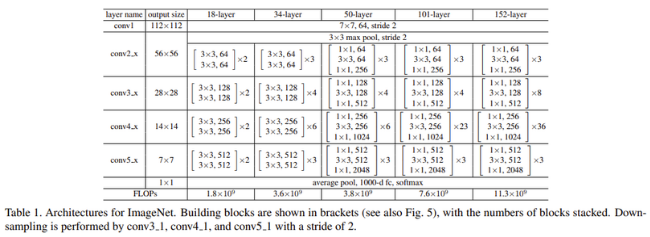

## 4-1. ResNet-34

# 블록 생성하기

In [25]:
def budild_resNet34_identity(input_layer, channel, block_num):
    # 입력 레이어
    x = input_layer
    
    # shortcut
    shortcut = input_layer

    # CNN 레이어-1
    x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=3,
            strides=1,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv1'
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # CNN 레이어-2
    x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=3,
            strides=1,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv2'
    )(x)
    x = keras.layers.BatchNormalization()(x)    
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.ReLU()(x)

    return x

In [26]:
def budild_resNet34_projection(input_layer, channel, block_num):
    # 입력 레이어
    x = input_layer

    # CNN 레이어-1
    x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=3,
            strides=2,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv1'
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # CNN 레이어-2
    x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=3,
            strides=1,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv2'
    )(x)
    x = keras.layers.BatchNormalization()(x)    

    # projection의 shortcut
    shortcut = input_layer
    shortcut = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            strides=2,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_shortcut'
    )(shortcut)
    shortcut = keras.layers.BatchNormalization()(shortcut)

    #
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.ReLU()(x)

    return x

# Identity block 확인

- 입력 레이어: (32,32,3)
- 입력 레이어를 인자로 받아 identity_block()은 블록의 레이어를 build하고 출력값을 얻을 수 있음
- 케라스의 Model 클래스에서 input과 output을 정의해서 간단히 블록의 모델 확인

In [27]:
resnet_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
# x = keras.layers.ZeroPadding2D(padding=(3,3))(resnet_input_layer)
x = resnet_input_layer
x = keras.layers.Conv2D(
            filters=64,
            kernel_size=7,
            strides=2,
            padding='same',
    )(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.ReLU()(x)

x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

# ResNet-34 identity 블록 확인
resnet_34_identity_block = budild_resNet34_identity(x, 64, 2)

In [28]:
# 블록 1개짜리 Resnet-34 Indentity Block 모델 생성
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_34_identity_block)  
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_4[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 16, 16, 64)   0           ['batch_normalization[0][0]

# Projection 블록 확인

- identity_block의 출력 결과를 입력 레이어로 받아 projection_block() 블록 모델 확인

In [29]:
# ResNet-34 Projection 블록 확인
resnet_34_projection_block = budild_resNet34_projection(x, 128, 3)

In [40]:
# 블록 1개짜리 Resnet-34 [Identity + Projection] Block 모델 생성
model = keras.Model(inputs=resnet_input_layer, outputs=resnet_34_projection_block)  
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 64)   9472        ['input_4[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 re_lu (ReLU)                   (None, 16, 16, 64)   0           ['batch_normalization[0][0]

### ResNet 34 Complete

In [48]:
def build_resnet_34(input_shape=(32,32,3), filter_num_list=[64, 128, 256, 512], num_classes=10):
    resnet_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
    # x = keras.layers.ZeroPadding2D(padding=(3,3))(resnet_input_layer)
    x = resnet_input_layer

    # conv1
    x = keras.layers.Conv2D(
                filters=64,
                kernel_size=7,
                strides=2,
                padding='same',
        )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # conv2
    x = keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')(x)

    x = budild_resNet34_identity(x, 64, '2-1')
    x = budild_resNet34_identity(x, 64, '2-2')
    x = budild_resNet34_identity(x, 64, '2-3')

    # conv3
    x = budild_resNet34_projection(x, 128, '3-1')
    x = budild_resNet34_identity(x, 128, '3-2')
    x = budild_resNet34_identity(x, 128, '3-3')
    x = budild_resNet34_identity(x, 128, '3-4')

    # conv4
    x = budild_resNet34_projection(x, 256, '4-1')
    x = budild_resNet34_identity(x, 256, '4-2')
    x = budild_resNet34_identity(x, 256, '4-3')
    x = budild_resNet34_identity(x, 256, '4-4')
    x = budild_resNet34_identity(x, 256, '4-5')
    x = budild_resNet34_identity(x, 256, '4-6')

    # conv5
    x = budild_resNet34_projection(x, 512, '5-1')
    x = budild_resNet34_identity(x, 512, '5-2')
    x = budild_resNet34_identity(x, 512, '5-3')

    output = keras.layers.GlobalAveragePooling2D()(x)
    # output = keras.layers.AveragePooling2D()(x)
    output = keras.layers.Flatten(name='flatten')(output)
    # output = keras.layers.Dense(10, activation='softmax', name='fc1000')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='fc1000')(output)

    model = keras.Model(
        inputs=resnet_input_layer, 
        outputs=output
    )
    return model

# 논문에서 fc-1000이 flatten해주고 1000개의 dense층을 하나 더 구현해야하는건줄 알았는데 아니었다 충격적..

In [49]:
resnet_34 = build_resnet_34()
resnet_34.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 64)   9472        ['input_12[0][0]']               
                                                                                                  
 batch_normalization_258 (Batch  (None, 16, 16, 64)  256         ['conv2d_8[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 re_lu_236 (ReLU)               (None, 16, 16, 64)   0           ['batch_normalization_258[0

In [50]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


195/195 [==============================] - 29s 98ms/step - loss: 2.3992 - accuracy: 0.2320 - val_loss: 2.5552 - val_accuracy: 0.1032
Epoch 2/15
195/195 [==============================] - 18s 94ms/step - loss: 1.8251 - accuracy: 0.3560 - val_loss: 2.5813 - val_accuracy: 0.1661
Epoch 3/15
195/195 [==============================] - 18s 93ms/step - loss: 1.5895 - accuracy: 0.4313 - val_loss: 1.7714 - val_accuracy: 0.3620
Epoch 4/15
195/195 [==============================] - 18s 91ms/step - loss: 1.3980 - accuracy: 0.5016 - val_loss: 1.6100 - val_accuracy: 0.4242
Epoch 5/15
195/195 [==============================] - 18s 91ms/step - loss: 1.2397 - accuracy: 0.5598 - val_loss: 1.6398 - val_accuracy: 0.4350
Epoch 6/15
195/195 [==============================] - 19s 99ms/step - loss: 1.0925 - accuracy: 0.6186 - val_loss: 1.5936 - val_accuracy: 0.4531
Epoch 7/15
195/195 [==============================] - 18s 91ms/step - loss: 0.9235 - accuracy: 0.6826 - val_loss: 1.6089 - val_accuracy: 0.4577
Epo

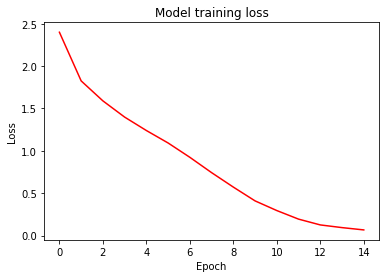

In [51]:
plt.plot(history_resnet34.history['loss'], 'r')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

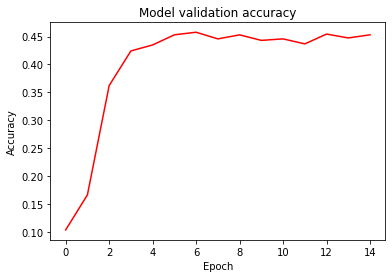

In [52]:
plt.plot(history_resnet34.history['val_accuracy'], 'r')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

## 4-2. ResNet-50

# 블록 생성하기

In [ ]:
def budild_resNet50_identity(input_layer, channel, block_num):
    # 입력 레이어
    x = input_layer
    
    # shortcut
    shortcut = input_layer

    # CNN 레이어-1
    x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=1,
            strides=1,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv1'
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # CNN 레이어-2
    x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=3,
            strides=1,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv2'
    )(x)
    x = keras.layers.BatchNormalization()(x)    
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.ReLU()(x)

    return x

In [ ]:
def budild_resNet50_projection(input_layer, channel, block_num):
    # 입력 레이어
    x = input_layer

    # CNN 레이어-1
    x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=3,
            strides=2,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv1'
    )(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)

    # CNN 레이어-2
    x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=3,
            strides=1,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv2'
    )(x)
    x = keras.layers.BatchNormalization()(x)    

    # projection의 shortcut
    shortcut = input_layer
    shortcut = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1,1),
            strides=2,
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_shortcut'
    )(shortcut)
    shortcut = keras.layers.BatchNormalization()(shortcut)

    #
    x = keras.layers.Add()([x, shortcut])
    x = keras.layers.ReLU()(x)

    return x

# 기타공부

1. global average pooling은 무엇인가, average pooling과 어떤 차이가 있는가
2. Error : Input has undefined rank. Received: input_shape=\<unknown\>.
> https://stackoverflow.com/questions/69085333/input-has-undefined-rank-tensorshapenone-error-in-building-resnet

> conv2d()(input) 구조이다 ^^ 코딩잘못하면 고생해 ^^
3. Introduction에 underlying mapping과 residual mapping 부분이 이해가 안됐었음, 아래부분은 공부하고 이해한 내용을 정리한 것.

<용어 정리>
1. few stacked layer : 딥러닝의 블록을 의미. 보통 딥러닝이 여러개의 층으로 구성된 1개의 블록이 반복되는 형식이던데, block을 풀어서 few stacked layer라고 한것 같음.

2. underlying mapping (original mapping과 동일) : 정답을 Y, input data를 X라고 하면, 딥러닝에서 학습을 진행하는것은 WX -> Y로 맵핑되도록 학습하는 것. 근데 이게 학습 전체에서 Y로 맵핑되는것을 의미하는건 아닌 것 같고, Hidden layer 1-> Hidden layer 2, Hidden layer 2-> Hidden layer3, 이런 과정의 반복하면서 Y로 맵핑이 되는데 underlying mapping은 이 요소 중 1개(즉, Hidden layer 2-> Hidden layer3 혹은 Hidden layer 3-> Hidden layer 4)가 정답으로 가까워지도록 학습되는걸 underlying mapping이라고 한것 같음.

3. residual mapping : 원래 underlying mapping은 Hidden layer2 자체값을 이용해서 Hidden layer 3번이 학습하는데, ResNet에서는 Hidden layer2의 output을 x라고하면 x + residual 값을 Hidden layer 3번이 학습하게됨. 이를 residual mapping에 맞춰서 학습을 하게된다고 하는것 같음.

4. stacked nonlinear layer : few stacked layer 의미의 연장선. residual blcok(short cut이 적용된 유우명한 블록 사진있자나여~)에서 마지막은 결국 relu activation을 통과함. 그래서 stacked nonlinear layer라고 하는듯합니다. (즉, 1개의 레이어를 의미하는게 아니라, residual block 자체를 의미)

< 내용 설명 >

ResNet에서는 기존에 underlying mapping에 맞춰서 학습하던 네트워크들과 달리, residual mapping에 맞춰서 학습하도록 수정되어있다. (이걸 수식으로 표현하면 Fx Hx 어쩌고가 되는듯.)

residual block은 Vgg에서 새로 추가된 블록이다.(resnet이 VGG에서 파생된걸로 알고있음, 추가된 layer이라고 생각하면 된다는 의미가 정말 layer 자체가 추가된게 아니라, VGG 아키텍처에서, 새로 추가된 아키텍처라는 의미인듯) resNet에서 original mapping은 Fx +x 로, residaul mapping이 된 형태이다.
(동일한 내용을 아랫문단에서 한번 더설명한거같음)


4. resnet-34에서 마지막 fc 1000은 Dense층을 1000 더 만들라는 의미 아니었나..?
